# Interferogram Analysis

This is the calculation workflow for the AIChE presentation [Opportunities in Spectroscopic Analysis: Chemometrics++](https://aiche.confex.com/aiche/2015/webprogram/Paper430942.html)

It aims to process a series of raw interferograms into a predictive chemometric model using a variety of approaches available in Python.

Before we get started; try setting up a parallel op (an ipython cluster must already be running): 

In [1]:
from IPython.parallel import Client
rc = Client()
dview = rc.direct_view()
dview.block = True


### Preliminaries

load some libraries to support the analysis - `numpy` for basic matrix operations, `pandas` for working with data tables, `matplotlib` for plotting, `theano` and `lasagne` for neural nets, `deap` for genetic algorithm, `sklearn` for the rest of the machine learning algorithms.  These are sent to all of the workers using the `%%px --local` command at the start of the cell.

In [2]:
%%px --local
import warnings
import numpy as np
import theano
import theano.tensor as T
import lasagne
import time
import matplotlib.pyplot as pl
import pandas as pd
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing,cross_validation
from scipy.signal import savgol_filter
from scipy.stats import pearsonr
import itertools
import deap
import scipy.io as sio
from random import shuffle

In [3]:
warnings.filterwarnings('ignore')
%matplotlib inline 
#%matplotlib qt
print lasagne.__version__
print deap.__version__

0.2.dev1
1.0


# Import Data

In [6]:
# locate data files:
filepath=r'/mnt/data/'
filename_counter_train=range(1,4)
filename_counter_test=range(4,7)
filenameroots=['753_6mg_25ml_biphenyl_in_acn','257_7 mg per 25ml biphenyl in acn','75_3 mg per 25ml biphenyl in acn',
               '24_7 mg per 25ml biphenyl in acn',
               '7_4 mg per 25ml biphenyl in acn','1_8 mg per 25ml biphenyl in acn','solvent acn','acn blank','emptyvial',
               'air background']
conclevels=np.array([30.144,10.308,3.012,0.988,0.296,0.072,0])
# create empty data frames:
Sraw_train=pd.DataFrame()
Sraw_test=pd.DataFrame()
# load data:
for roots in filenameroots:
    
    for n in filename_counter_train:
        temp=pd.read_csv(filepath+roots+' '+'{:03d}'.format(n)+'.csv',header=None)
        #negative sign is needed for this particular set of data:
        Sraw_train[roots+' '+'{:03d}'.format(n)]=-temp[1]
    for n in filename_counter_test:
        temp=pd.read_csv(filepath+roots+' '+'{:03d}'.format(n)+'.csv',header=None)
        #negative sign is needed for this particular set of data:
        Sraw_test[roots+' '+'{:03d}'.format(n)]=-temp[1]
isblank=[0,0,0,0,0,0,0,0,0,1]
isignored=[0,0,0,0,0,0,1,1,1,1]
specrange=[1034,2586] # arbitrary wavenumber units, 1034:2586 is roughtly equal to 4000-10000 cm^-1
bpfilter=np.zeros(Sraw_test.shape[0])
bpfilter[specrange[0]:specrange[1]]=1

fftwin=np.fft.ifft((bpfilter))


Examine data to be sure they are ifgs...

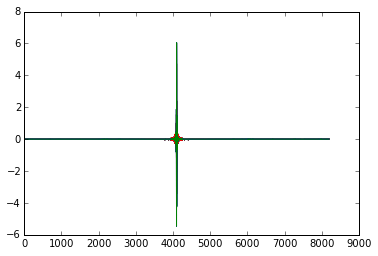

In [7]:
pl.figure(figsize=(6,4))
for samp in Sraw_train:
    pl.plot((Sraw_train[samp]),label=samp)


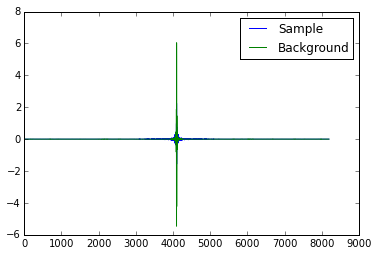

In [8]:
pl.figure(figsize=(6,4))
pl.plot(Sraw_train['753_6mg_25ml_biphenyl_in_acn 001'],label='Sample')
pl.plot(Sraw_train['air background 001'],label='Background')
pl.legend(loc='best')

## Define useful functions

In [9]:
%%px --local
def hg(S,centerburst=True):
    # HAPP-GENZEL apodization function (Griffiths, Eq 2.24)
    if not centerburst:
        print 'shifting'
        S=np.fft.fftshift(S)
    A=np.complex_(np.zeros(len(S)))
    for i in xrange(len(S)):
        A[i] = (0.54+0.46*np.cos(np.pi*2*(i-len(S)/2)/len(S)))*S[i]
    return(np.real(A))

def phc_mertz(Braw):
    # MERTZ phase correction
    th_nu=np.arctan(np.imag(Braw)/np.real(Braw)) # find phase angle (MERTZ) Griffiths eq. 4.35
    B=phc(Braw,th=th_nu)
    return B

def phc(Braw,th=0):
    B=np.real(Braw)*np.cos(th)+np.imag(Braw)*np.sin(th) # apply phase correction Griffiths ea. 4.34
    return B

def phc_forman(Sraw):
    # FORMAN phase correction
    Braw=np.fft.fft(np.fft.fftshift(Sraw)) # get FFT
    th_nu=np.arctan(np.imag(Braw)/np.real(Braw)) # find phase angle (FORMAN) Griffiths eq. 4.35
    mask=np.zeros(len(th_nu))
    mask[range(specrange[0],specrange[1]+1)]=1
    th_nu=th_nu#*mask  # the masking of th_nu was removed as its not really needed.
    th_del=np.fft.fftshift(np.fft.ifft(th_nu)) #  Griffiths eq. 4.37
    S=np.convolve(Sraw,th_del,mode='same') # apply phase correction Griffiths ea. 4.38
    S=np.convolve(S,fftwin,mode='same')
    return np.real(S)

def ifg2spec(S):
    Shg=hg(S) # apodize, 
    Braw=np.fft.fft(np.fft.fftshift(Shg)) # get FFT
    B=phc_mertz(Braw) # phase correct
    B=B*bpfilter # isolate spectrum
    mp=len(B)/2 # find midpoint
    return np.real(B[1:mp])  # return only half of the real spectrum

def mcs(A):
    # mean center and scale data, ignoring nans
    mn=np.nanmean(A)
    sg=np.nanstd(A)
    return (A-mn)/sg

def bl(B):
    x=linspace(B[0],B[-1],len(B))
    return x

def rmse(pred,actual,wt=1.):
    wt=wt/np.sum(wt) # normalize wt
    return np.sqrt(sum(((pred-actual)*wt)**2))

In [10]:
%%px --local
from lasagne.layers import *
from lasagne.nonlinearities import linear,tanh, rectify
from lasagne.utils import floatX

class trainNN:
    '''A class for training a lasagne NN'''
    def __init__(self,num_epochs=8000,n_dens1=20,n_dens2=10):
        self.num_epochs=num_epochs
        self.n_dens1=n_dens1
        self.n_dens2=n_dens2
        self.net = {} # use a dict to hold all of the layers    
    def fit(self,d_raw,c_raw):
        if np.ndim(c_raw) ==1:
            c_raw=c_raw[:,np.newaxis]   # ensure that y is a matrix
        
        epoch_err=np.zeros(self.num_epochs)
        self.scaler = preprocessing.StandardScaler().fit(d_raw)
        d=self.scaler.transform(d_raw)
        self.yscaler=preprocessing.StandardScaler().fit(c_raw)
        c=self.yscaler.transform(c_raw)
        
        input_var=T.tensor3('inputs') #(SAMPLESIZE,LAYER,INPUTPOINTS)
        target_var=T.matrix('target') #(SAMPLSIZE,OUTPUTCONCS)
        net = {} # use a dict to hold all of the layers
        net['input'] = InputLayer(shape=(None,1, d.shape[1]),
                                  input_var=input_var)

        #net['conv1'] = Conv1DLayer(net['input'], num_filters=10, filter_size=20)

        #net['pool1'] = MaxPool1DLayer(net['input'], pool_size=3, stride=2)
        net['drop1'] = DropoutLayer(net['input'], p=0.25)
        net['dens1']=DenseLayer(net['drop1'] , num_units=self.n_dens1,nonlinearity=tanh)

        net['dens2']=DenseLayer(net['dens1'] , num_units=self.n_dens2,nonlinearity=tanh)
        #net['drop2'] = DropoutLayer(net['drop1'], p=0.5)
        #net['dens2']=DenseLayer(
        #        net['drop2'] , num_units=10,
        #        nonlinearity=lasagne.nonlinearities.rectify)
        #net['bias']=BiasLayer(net['dens2'])
        net['output'] = DenseLayer(
                net['dens2'], num_units=c.shape[1],
                nonlinearity=linear)

        prediction = lasagne.layers.get_output(net['output'])
        loss = lasagne.objectives.squared_error(prediction, target_var)
        loss = loss.mean()

        params = lasagne.layers.get_all_params(net['output'], 
                                               trainable=True)
        updates = lasagne.updates.nesterov_momentum(
                loss, params, learning_rate=0.01, momentum=0.9)

        test_prediction = lasagne.layers.get_output(net['output'], deterministic=True)
        test_loss = lasagne.objectives.squared_error(test_prediction,
                                                                target_var)
        test_loss = test_loss.mean()

        test_acc = T.mean(T.eq(T.argmax(test_prediction, axis=1), target_var),
                          dtype=theano.config.floatX)

        train_fn = theano.function([input_var, target_var], loss, updates=updates)

        val_fn = theano.function([input_var, target_var], test_loss)

        for epoch in range(self.num_epochs):
            # In each epoch, we do a full pass over the training data:
            train_err = train_fn(d[:,np.newaxis,:], c)
            epoch_err[epoch]=train_err
        self.net=net
        self.epoch_err=epoch_err

    def predict(self,dtest_raw):
    # calculate predictions using the trained model
        dtest=self.scaler.transform(dtest_raw)
        self.NNpred = self.yscaler.inverse_transform(np.array(get_output(self.net['output'], floatX(dtest[:,np.newaxis,:])).eval()))
        
        return self.NNpred

In [11]:
%%px --local
import random
from deap import creator, base, tools, algorithms

class GA:
    def __init__(self,modl,NGEN=1000,testsize=0.5):
        self.modl=modl
        self.NGEN=NGEN
        self.testsize=testsize

    def evalFun(self,individual):
        mask=np.repeat(np.array(individual,ndmin=2),self.X_train.shape[0],axis=0)
        maskCV=np.repeat(np.array(individual,ndmin=2),self.X_CVtest.shape[0],axis=0)
        self.modl.fit(self.X_train*mask,self.y_train)
        err=rmse(self.modl.predict(self.X_CVtest*maskCV),self.y_CVtest[:,np.newaxis]) 
        return err,
        
    def fit(self,Xtrain,ytrain):
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMin)
        toolbox = base.Toolbox()
        toolbox.register("attr_bool", random.randint, 0, 1)
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
        toolbox.register("select", tools.selTournament, tournsize=10)
        toolbox.register("evaluate", self.evalFun)
        popSize=Xtrain.shape[1]
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, popSize)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        population = toolbox.population(n=64)

        for gen in range(self.NGEN):
            self.X_train, self.X_CVtest, self.y_train, self.y_CVtest = cross_validation.train_test_split(Xtrain, 
                                                                                         ytrain, 
                                                                                         test_size=self.testsize)
            offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.01)
            fits = toolbox.map(toolbox.evaluate, offspring)
            for fit, ind in zip(fits, offspring):
                ind.fitness.values = fit
            population = toolbox.select(offspring, k=len(population))
        self.top1 = tools.selBest(population, k=1)
        
    def predict(self,Xtest):
        mask=np.repeat(np.array(self.top1,ndmin=2),Xtest.shape[0],axis=0)
        return self.modl.predict(Xtest*mask)

Set up wrapper for a basic genetic algorithim [from DEAP example](https://github.com/DEAP/deap)

# Convert interferograms to spectra

Define some relationships:
The single-beam spectra $B$ is calculated from the interferogram using a discrete fourier transform (Griffiths Eq. 4.34):

$$B\left(\nu\right)=\mathcal{F}\left(S\left(x\right)\right)$$

$$B={\rm Re}(\mathcal{F}(S)){\rm cos}\theta_{\nu}+{\rm Im}(\mathcal{F}(S)){\rm sin}\theta_{\nu}$$ 

Where phase angle $\theta_{\nu}$ is defined as (Griffiths Eq. 4.35):

$$\theta_{\nu}={\rm arctan}\frac{{\rm Im}(\mathcal{F}(S))}{{\rm Re}(\mathcal{F}(S))}$$

Absorbance $A$ is defined as the log ratio of the sample and background transmission spectra:

$$A = -log_{10}\frac{B_s}{B_{bg}} = -log_{10}\left(1+\frac{(B_s-B_{bg})}{B_{bg}}\right)$$

$$A= -log_{10}\left(1+\frac{\mathcal{F}(S_s-S_{bg})}{\mathcal{F}(S_{bg})}\right)$$

Use air background spectra as reference:

In [12]:
B_train=pd.DataFrame()
S_train=pd.DataFrame()
C_train=np.zeros(Sraw_train.shape[1]-3*sum(isignored))   # create training vector of concentrations
B_test=pd.DataFrame()
S_test=pd.DataFrame()
C_test=np.zeros(Sraw_train.shape[1]-3*sum(isignored))   # create training vector of concentrations

# get beam spectra baseline:
for ix,samp in enumerate(Sraw_train):
    if ix<(Sraw_train.shape[1]-3*sum(isignored)):
        C_train[ix]=conclevels[np.floor(ix/3)]
    B_train[samp]=ifg2spec(Sraw_train[samp])#-(np.min(ifg2spec(Sraw_train[samp])))+1e-5
    S_train[samp]=phc_forman(Sraw_train[samp])

for ix,samp in enumerate(Sraw_test):
    if ix<(Sraw_test.shape[1]-3*sum(isignored)):
        C_test[ix]=conclevels[np.floor(ix/3)]
    B_test[samp]=ifg2spec(Sraw_test[samp])#-(np.min(ifg2spec(Sraw_test[samp])))+1e-5
    S_test[samp]=phc_forman(Sraw_test[samp])


In [13]:
B2A_train=pd.DataFrame()
B_BG=np.mean(B_train.ix[:,(isblank.index(1)*3):(isblank.index(1)*3+3)],axis=1)
for ix,samp in enumerate(B_train):
    if ix<(Sraw_train.shape[1]-3*sum(isignored)):
        B2A_train[samp]=-np.log10((np.array(1+(B_train[samp]-B_BG)/B_BG)))
        B2A_train[samp][np.isnan(B2A_train[samp])]=3

S2A_train=pd.DataFrame()
S_BG=(np.mean(S_train.ix[:,(isblank.index(1)*3):(isblank.index(1)*3+3)],axis=1))
for ix,samp in enumerate(S_train):
    if ix<(Sraw_train.shape[1]-3*sum(isignored)):
        S2A_train[samp]=-np.log10(1+np.real(np.fft.fft(np.fft.fftshift((S_train[samp]-S_BG))))/np.real(np.fft.fft(np.fft.fftshift(S_BG))))
        
B2A_test=pd.DataFrame()
B_BGtest=np.mean(B_test.ix[:,(isblank.index(1)*3):(isblank.index(1)*3+3)],axis=1)
for ix,samp in enumerate(B_test):
    if ix<(Sraw_test.shape[1]-3*sum(isignored)):
        B2A_test[samp]=-np.log10(1+(B_test[samp]-B_BGtest)/B_BGtest)
        B2A_test[samp][np.isnan(B2A_test[samp])]=3

S2A_test=pd.DataFrame()
S_BGtest=(np.mean(S_test.ix[:,(isblank.index(1)*3):(isblank.index(1)*3+3)],axis=1))
for ix,samp in enumerate(S_test):
    if ix<(Sraw_test.shape[1]-3*sum(isignored)):
        S2A_test[samp]=-np.log10(1+(np.fft.fft(np.fft.fftshift(S_test[samp]-S_BGtest)))/np.fft.fft(np.fft.fftshift(S_BGtest)))

In [14]:
print B_train.columns

Index([u'753_6mg_25ml_biphenyl_in_acn 001',
       u'753_6mg_25ml_biphenyl_in_acn 002',
       u'753_6mg_25ml_biphenyl_in_acn 003',
       u'257_7 mg per 25ml biphenyl in acn 001',
       u'257_7 mg per 25ml biphenyl in acn 002',
       u'257_7 mg per 25ml biphenyl in acn 003',
       u'75_3 mg per 25ml biphenyl in acn 001',
       u'75_3 mg per 25ml biphenyl in acn 002',
       u'75_3 mg per 25ml biphenyl in acn 003',
       u'24_7 mg per 25ml biphenyl in acn 001',
       u'24_7 mg per 25ml biphenyl in acn 002',
       u'24_7 mg per 25ml biphenyl in acn 003',
       u'7_4 mg per 25ml biphenyl in acn 001',
       u'7_4 mg per 25ml biphenyl in acn 002',
       u'7_4 mg per 25ml biphenyl in acn 003',
       u'1_8 mg per 25ml biphenyl in acn 001',
       u'1_8 mg per 25ml biphenyl in acn 002',
       u'1_8 mg per 25ml biphenyl in acn 003', u'solvent acn 001',
       u'solvent acn 002', u'solvent acn 003', u'acn blank 001',
       u'acn blank 002', u'acn blank 003', u'emptyvial 001', u'emp

## Examine data

Plot single-beam spectras:

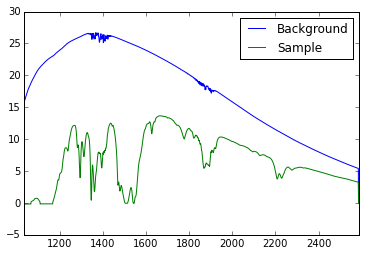

In [15]:
pl.figure(figsize=(6,4))
pl.plot(B_train['air background 001'],label='Background')
pl.plot(B_train['753_6mg_25ml_biphenyl_in_acn 001'],label='Sample')
pl.xlim(specrange)
pl.legend(loc='best')

Absorbance Spectras:

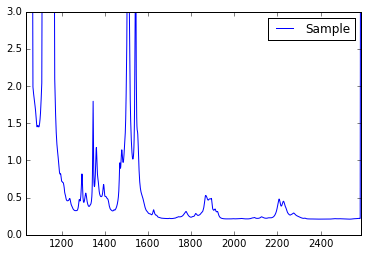

In [16]:
pl.figure(figsize=(6,4))
pl.plot(B2A_train['753_6mg_25ml_biphenyl_in_acn 001'],label='Sample')
pl.xlim(specrange)
pl.legend(loc='best')

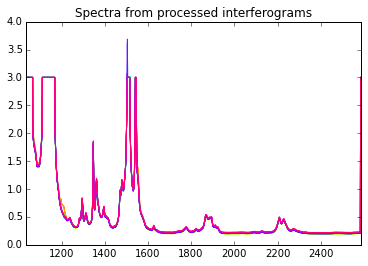

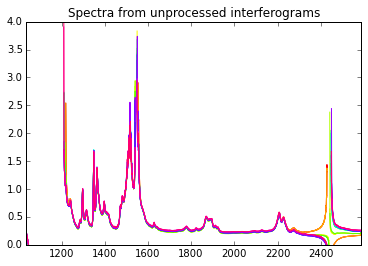

In [17]:
pl.figure(figsize=(6,4))
cmap = pl.get_cmap('hsv')
N=len(B2A_train.columns)
for ix,samp in enumerate(B2A_train):
    color = cmap(float(ix)/N)
    pl.plot(B2A_train[samp],label=str(C_train[ix]),color=color)
pl.xlim(specrange)
pl.ylim([0,4])
pl.title("Spectra from processed interferograms")

pl.figure(figsize=(6,4))
N=len(S2A_train.columns)
for ix,samp in enumerate(S2A_train):
    color = cmap(float(ix)/N)
    pl.plot(S2A_train[samp],label=str(C_train[ix]),color=color)
pl.xlim(specrange)
pl.ylim([0,4])
pl.title("Spectra from unprocessed interferograms")

# Calculate First Derivatives of Spectra:

Use savitsky-golvay smoother to calculate derivatives of spectra

In [18]:
B2dA_train=pd.DataFrame()
for ix,samp in enumerate(B2A_train):
    B2dA_train[samp]=savgol_filter(B2A_train[samp],5,2,deriv=1)

B2dA_test=pd.DataFrame()
for ix,samp in enumerate(B2A_test):
    B2dA_test[samp]=savgol_filter(B2A_test[samp],5,2,deriv=1)

Examine the spectral derivatives

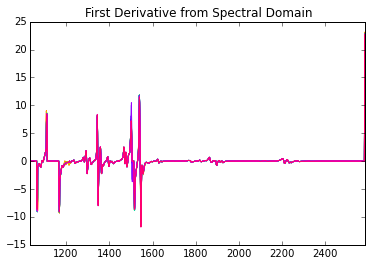

In [19]:
pl.figure(figsize=(6,4))
N=len(B2dA_train.columns)
for ix,samp in enumerate(B2dA_train):
    color = cmap(float(ix)/N)
    pl.plot(mcs(B2dA_train[samp]),label=str(C_train[ix]),color=color)
pl.xlim(specrange)
pl.title('First Derivative from Spectral Domain')


For time-domain derivatives of the spectra, use relationship

 $$\frac{dA}{d\nu} = \frac{1}{log(10)}\frac{B_s\frac{dB_{bg}}{d\nu}-B_{bg}\frac{dB_s}{d\nu}}{B_sB_{bg}}$$

Use the following relationship to explore differentiation $j\frac{d B}{d \nu}=\mathcal{F}(xS)$ with Fourier identities:

 $$\frac{dA}{d\nu} = \frac{1}{log(10)}\frac{B_s\frac{dB_{bg}}{d\nu}-B_{bg}\frac{dB_s}{d\nu}}{\mathcal{F}(S_s*S_{bg})} = \frac{-j}{log(10)}\frac{B_s\mathcal{F}(xS_{bg})-B_{bg}\mathcal{F}(xS_s)}{\mathcal{F}(S_s*S_{bg})}$$ 
 
 $$\frac{dA}{d\nu}  = \frac{-j}{log(10)}\frac{\mathcal{F}(S_s*xS_{bg}-S_{bg}*xS_s)}{\mathcal{F}(S_s*S_{bg})} $$
 
 $$xS$$

In [20]:
def calc_dA_timedomain(S_s,S_bg,ph0=0):
    if len(S_s)!=len(S_bg):
        raise ValueError('S_s and S_bg must have same length')
    x=np.linspace(1,len(S_s),num=len(S_s))
    S_s_shift=np.fft.fftshift(S_s)
    S_bg_shift=np.fft.fftshift(S_bg)
    conv1=np.convolve(S_s_shift,x*S_bg_shift,mode='same')
    conv2=np.convolve(S_bg_shift,x*S_s_shift,mode='same')
    conv3=np.convolve(S_s_shift,S_bg_shift,mode='same')
    dA=-1j*2*np.pi/np.log(10)/len(x)*(np.fft.fft(hg((conv1)-(conv2)))/np.fft.fft(hg(conv3)))
    mp=len(dA)/2
    return phc(dA[0:mp],ph0),conv1-conv2,conv3

In [21]:
S2dA_train=pd.DataFrame()
S2dAc1_train=pd.DataFrame()
S2dAc3_train=pd.DataFrame()
for ix, samp in enumerate(S_train):
      S2dA_train[samp],S2dAc1_train[samp],S2dAc3_train[samp]=calc_dA_timedomain(S_train[samp],S_BG)

S2dA_test=pd.DataFrame()
S2dAc1_test=pd.DataFrame()
S2dAc3_test=pd.DataFrame()
for ix, samp in enumerate(S_test):
     S2dA_test[samp],S2dAc1_test[samp],S2dAc3_test[samp]=calc_dA_timedomain(S_test[samp],S_BGtest)

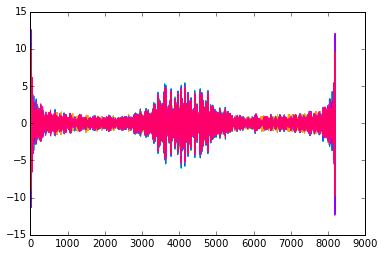

In [22]:
pl.figure(figsize=(6,4))
N=len(B2dA_train.columns)
for ix,samp in enumerate(B2dA_train):
    color = cmap(float(ix)/N)
    pl.plot(mcs(S2dAc1_train[samp]),label=str(C_train[ix]),color=color)

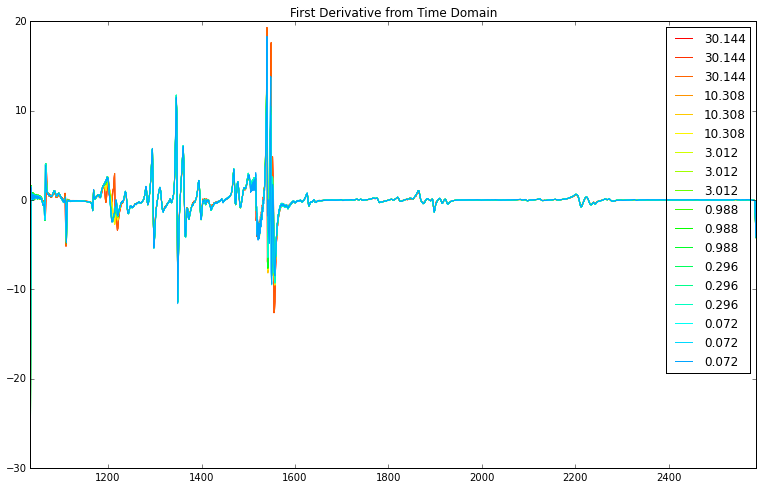

In [23]:
pl.figure(figsize=(13,8))
N=len(S2dA_train.columns)
for ix,samp in enumerate(S2dA_train):
    if ix<(Sraw_train.shape[1]-3*sum(isignored)):
        color = cmap(float(ix)/N)
        pl.plot(mcs(np.real(S2dA_train[samp])),label=str(C_train[ix]),color=color)
pl.legend()
pl.xlim(specrange)
pl.title('First Derivative from Time Domain')


# Chemometric modeling

## Regress PLS model on spectra

The next step is to compare the results of the standard approach to chemometrics, ye olde olden partial least squares regresssion.  Use the scikit-learn `PLSRegression` for fitting and prediction on the spectral domain set.  We limit the spectral range to the useful region of the spectrum.  Choose a reasonable number of pricipal componenets for the regression.

In [24]:
b=np.array(B2A_train.iloc[specrange[0]:specrange[1],:]) # tranform data into array for regression 
btest=np.array(B2A_test.iloc[specrange[0]:specrange[1],:]) # tranform data into array for regression 
db=np.array(B2dA_train.iloc[specrange[0]:specrange[1],:]) # tranform data into array for regression
dbtest=np.array(B2dA_test.iloc[specrange[0]:specrange[1],:]) # tranform data into array for regression 
s=np.array(S_train.iloc[:,:(isignored.index(1)*3)]) # tranform data into array for regression
stest=np.array(S_test.iloc[:,:(isignored.index(1)*3)]) # tranform data into array for regression 
ds=np.array(S2dAc1_train.iloc[:,:(isignored.index(1)*3)]) # tranform data into array for regression
dstest=np.array(S2dAc1_test.iloc[:,:(isignored.index(1)*3)])# tranform data into array for regression
ytrain=(C_train+1e-3)  # add a slight offset for numerical stability


Save the imported, processed data as a mat file to share with the other workers

In [25]:
sio.savemat('Data.mat',{'b':b,
                        'btest':btest,
                        'db':db,
                        'dbtest':dbtest,
                        's':s,
                        'stest':stest,
                        'ds':ds,
                        'dstest':dstest,
                        'ytrain':ytrain})

#Make chemometric models

Try Lasso, Lasso LARS, Ridge Regression, Bayesian Ridge Regression, Random Forest, and Gradient Boosted regression, Neural Nets in addition to PLS.  Because of the common commands of the scikit-learn library, and the earlier definitions of the neural net and genetic algorithm classes, it is easy to pipline all of the approaches.

In [26]:
%%px --local
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LassoLarsCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNetCV
from sklearn.cross_decomposition import PLSRegression

# define function to make it predictions a oneliner

def make_da_prediction(xtrain,xtest,ytrain,modl):
    scaler = preprocessing.StandardScaler().fit(xtrain)
    X=scaler.transform(xtrain)
    Xt=scaler.transform(xtest)
    yscaler=preprocessing.StandardScaler().fit(ytrain)
    y=yscaler.transform(ytrain)
    modl.fit(X,y)
    yt=yscaler.inverse_transform(modl.predict(Xt).flatten())
    return yt

Now load the data back onto each worker, again using `%%px --local`

In [27]:
%%px --local
mat_contents = sio.loadmat('Data.mat')  # load the processed data into each worker
b=mat_contents['b']
btest=mat_contents['btest']
db=mat_contents['db']
dbtest=mat_contents['dbtest']
s=mat_contents['s']
stest=mat_contents['stest']
ds=mat_contents['ds']
dstest=mat_contents['dstest']
ytrain=mat_contents['ytrain'][0]

predictions=pd.DataFrame()
predictions['True']=ytrain

In [28]:
%%px --local
pls7=PLSRegression(n_components=7)  
pls6=PLSRegression(n_components=6) 
pls5=PLSRegression(n_components=5)  
pls4=PLSRegression(n_components=4)  # TODO: add PRESS selection for number of components, not this sillyness
pls3=PLSRegression(n_components=3)  
ols=LinearRegression()
lasso=LassoCV(alphas=np.logspace(-10,0,20))
ridge=RidgeCV(alphas=np.logspace(-10,0,20))
elasticNet=ElasticNetCV(l1_ratio =[.1, .5, .7, .9, .95, .99, 1])
baridge=BayesianRidge(alpha_1=0.001)
rf=RandomForestRegressor(random_state=0,n_estimators=100)
lars=LassoLarsCV()
gb=GradientBoostingRegressor(loss='huber')
nn=trainNN(num_epochs=1000,n_dens1=50,n_dens2=10)
models={'PLS_3':pls3,
        'PLS_4':pls4,
        'PLS_5':pls5,
        'PLS_6':pls6,
        'PLS_7':pls7,
        'GA-PLS_3':GA(pls3),
        'GA-PLS_4':GA(pls4),
        'GA-PLS_5':GA(pls5),
        'GA-PLS_6':GA(pls6),
        'GA-PLS_7':GA(pls7),
        'OLS':ols,
        'Lasso':lasso,
        'Ridge':ridge,
        'Elastic Net':elasticNet,
        'Bayes Ridge':baridge,
        'LassoLARS':lars,
        'Random Forest':rf,
        'GB':gb,
        'Neural Net':nn}

dataSets={'Full Ifg':[s.T,stest.T],
          'Ifg Deriv':[ds.T,dstest.T],
          'Full Spectra':[b.T,btest.T],
          'Spectra Deriv':[db.T,dbtest.T]}

allCombinationsOfModelsAndDatasets=itertools.product(models,dataSets)

def parMake_da_prediction((model,dataSet)):
    descr= model + ' Predictions from '+ dataSet
    print descr
    pred=make_da_prediction(dataSets[dataSet][0],dataSets[dataSet][1],ytrain,models[model])
    return descr,pred

In [29]:
%%time
# this could be run in parallel
for (model,dataSet) in allCombinationsOfModelsAndDatasets:
    descr,pred=parMake_da_prediction((model,dataSet))
    predictions[descr]=pred

Bayes Ridge Predictions from Ifg Deriv
Bayes Ridge Predictions from Spectra Deriv
Bayes Ridge Predictions from Full Ifg
Bayes Ridge Predictions from Full Spectra
Ridge Predictions from Ifg Deriv
Ridge Predictions from Spectra Deriv
Ridge Predictions from Full Ifg
Ridge Predictions from Full Spectra
Neural Net Predictions from Ifg Deriv
Neural Net Predictions from Spectra Deriv
Neural Net Predictions from Full Ifg
Neural Net Predictions from Full Spectra
PLS_3 Predictions from Ifg Deriv
PLS_3 Predictions from Spectra Deriv
PLS_3 Predictions from Full Ifg
PLS_3 Predictions from Full Spectra
PLS_7 Predictions from Ifg Deriv
PLS_7 Predictions from Spectra Deriv
PLS_7 Predictions from Full Ifg
PLS_7 Predictions from Full Spectra
PLS_6 Predictions from Ifg Deriv
PLS_6 Predictions from Spectra Deriv
PLS_6 Predictions from Full Ifg
PLS_6 Predictions from Full Spectra
PLS_5 Predictions from Ifg Deriv
PLS_5 Predictions from Spectra Deriv
PLS_5 Predictions from Full Ifg
PLS_5 Predictions from Ful

To go through all of the interations takes 6 mins when run one at a time

In [30]:
%%time
# use parallel mapping to speed computation
r=dview.map(parMake_da_prediction,itertools.product(models,dataSets))
for descr,pred in r:
    predictions[descr]=pred

CPU times: user 2min 14s, sys: 3.01 s, total: 2min 17s
Wall time: 24min 48s


Using the parallel computing, we get a run time that is 8x faster

## Analyze Results

Inspect table

In [31]:
predictions.tail()

,True,Bayes Ridge Predictions from Ifg Deriv,Bayes Ridge Predictions from Spectra Deriv,Bayes Ridge Predictions from Full Ifg,Bayes Ridge Predictions from Full Spectra,Ridge Predictions from Ifg Deriv,Ridge Predictions from Spectra Deriv,Ridge Predictions from Full Ifg,Ridge Predictions from Full Spectra,Neural Net Predictions from Ifg Deriv,...,GA-PLS_4 Predictions from Full Ifg,GA-PLS_4 Predictions from Full Spectra,GA-PLS_7 Predictions from Ifg Deriv,GA-PLS_7 Predictions from Spectra Deriv,GA-PLS_7 Predictions from Full Ifg,GA-PLS_7 Predictions from Full Spectra,GA-PLS_6 Predictions from Ifg Deriv,GA-PLS_6 Predictions from Spectra Deriv,GA-PLS_6 Predictions from Full Ifg,GA-PLS_6 Predictions from Full Spectra
13,0.297,0.954244,0.022720,0.854417,0.267907,0.954207,0.022711,0.854218,0.267117,0.046008,...,0.972519,0.035458,-3.012192,2.643400,-6.011282,-1.270240,-10.371295,0.046597,0.093516,0.055605
14,0.297,0.218022,-0.221645,0.413006,0.265783,0.217898,-0.221662,0.412843,0.261034,0.314308,...,1.149335,0.061966,-2.149993,2.349371,-3.458381,-1.218866,-10.725990,-0.068020,-0.336275,0.117807
15,0.073,0.134199,0.214984,0.151242,0.170791,0.134221,0.214974,0.151380,0.171514,0.079079,...,0.204960,1.180409,0.520222,2.794800,-3.614939,1.106069,-9.584888,-0.056519,0.646823,0.198841
16,0.073,0.057082,-0.010988,0.085186,0.099685,0.057082,-0.010998,0.085228,0.104464,0.078995,...,0.347162,1.065376,0.441494,3.039854,-2.051035,0.971649,-9.906561,-0.557840,0.648698,0.070652
17,0.073,0.025863,0.222193,0.366842,0.078257,0.025575,0.222185,0.366852,0.082351,0.244090,...,-0.778581,1.067979,-3.283995,3.193851,-7.678061,0.843859,-8.790979,-0.150993,-1.380776,0.135686


Plot the prediction results, now with the extra learners!  But first, define plotting function:

In [32]:
def plot_compare(datagrp):
    pl.figure(figsize=(13,8))
    medpred=predictions.groupby('True').median()
    N=len(medpred.columns)
    markers=['.','o','x','s']*20 # add a lot of repeats
    shuffle(markers)
    for ix,(pred,marker) in enumerate(zip(medpred,markers)):
        if pred.find(datagrp)>0:
            color=cmap(float(ix)/N)
            pl.loglog((medpred.index),abs(medpred[pred]),marker=marker,ls='None',label=pred,color=color)
    pl.loglog(([0.0005,40]),([0.0005,40]),'-k',label='Parity')
    pl.legend(loc='best')
    pl.title('Median Prediction on Test Set: '+datagrp)
    pl.xlabel('Actual mg/mL')
    pl.ylabel('Predicted mg/mL')
    pl.xlim(([0.0005,40]))
    pl.ylim(([0.0005,40]))

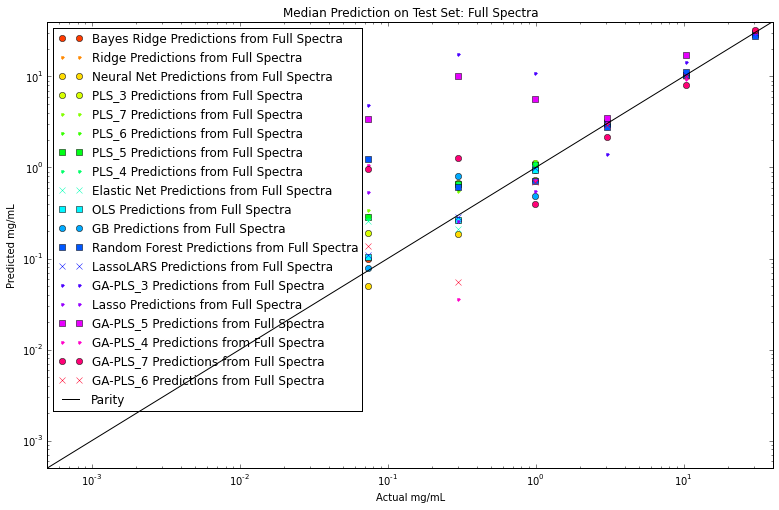

In [33]:
plot_compare('Full Spectra')

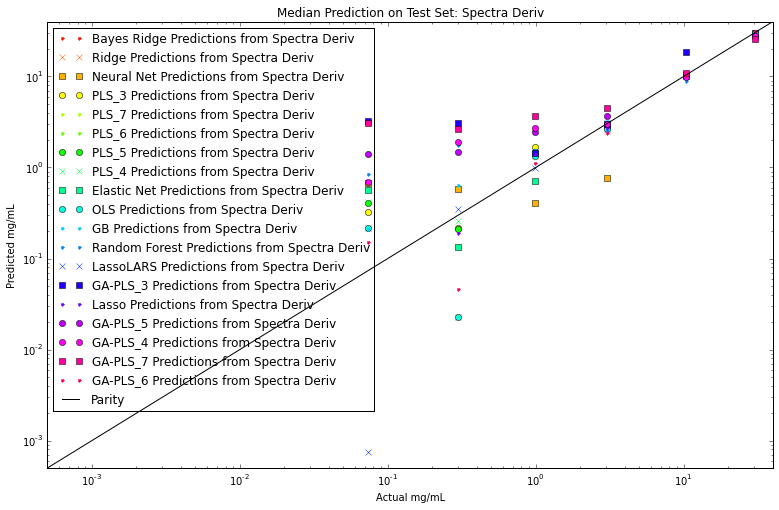

In [34]:
plot_compare('Spectra Deriv')

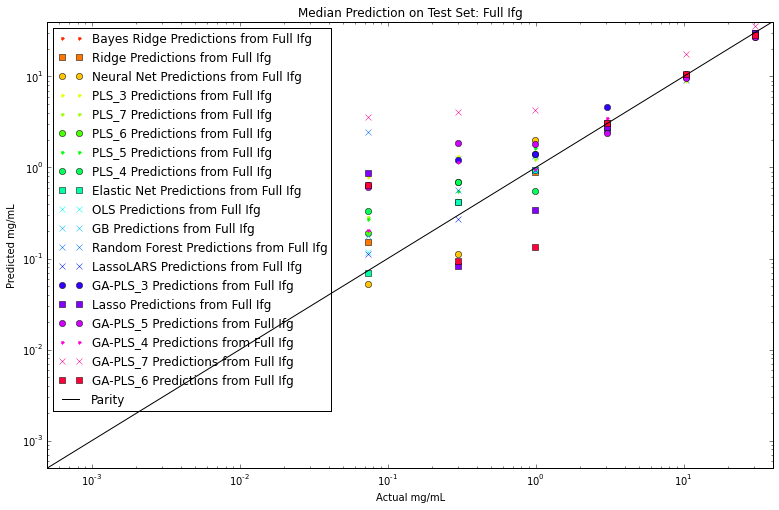

In [35]:
plot_compare('Full Ifg')

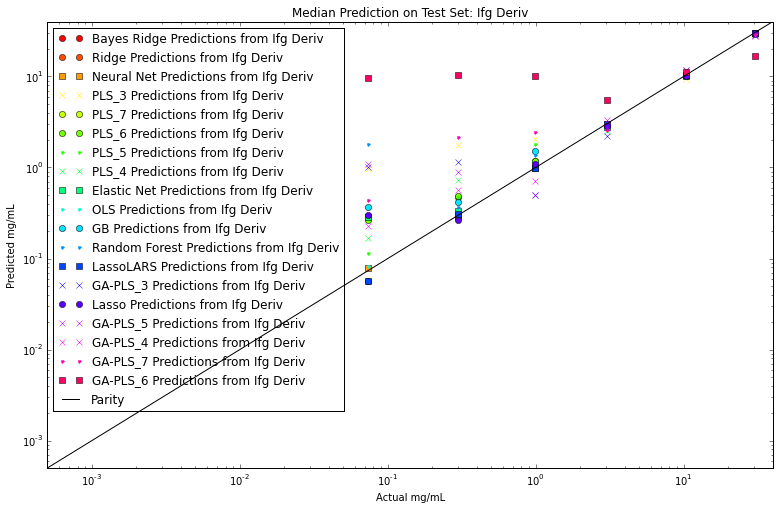

In [36]:
plot_compare('Ifg Deriv')

Recalculate RMSE and Pearson coefficients:

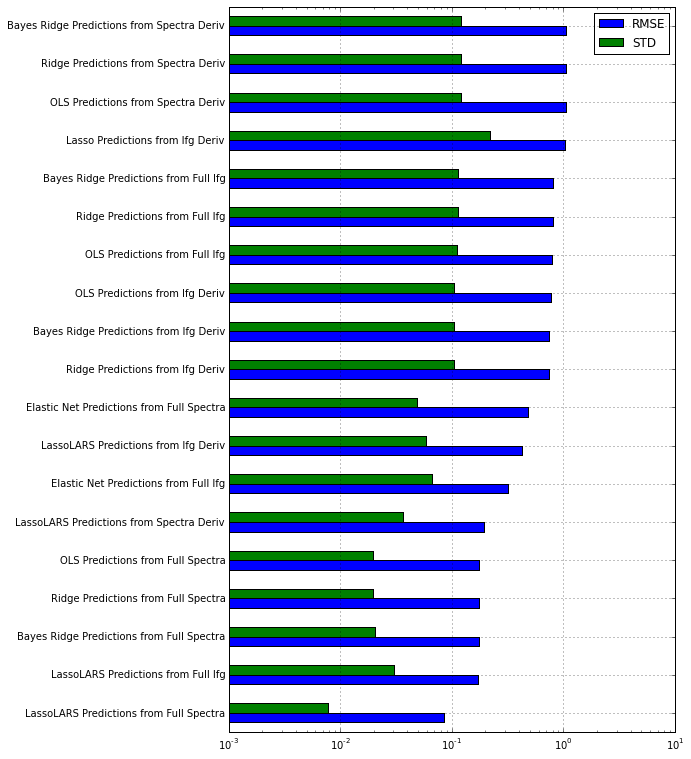

In [37]:
predRMSE=pd.DataFrame()
stdpred=predictions.groupby('True').std()

for ix,pred in enumerate(predictions):
    if ix>0:
        predRMSE[pred]= [rmse((predictions[pred]),(predictions['True']))]
    
predRMSE=predRMSE.rename(index={0:'RMSE'})
predRMSE=pd.concat([predRMSE.T.sort_index(),stdpred.mean()],ignore_index=False,axis=1)
predRMSE=predRMSE.rename(columns={0:'STD'})
#predRMSE.sort_index(by='RMSE')
predRMSE.sort_index(by='RMSE').head(19).plot(kind='barh',figsize=(8,13),logx=True)


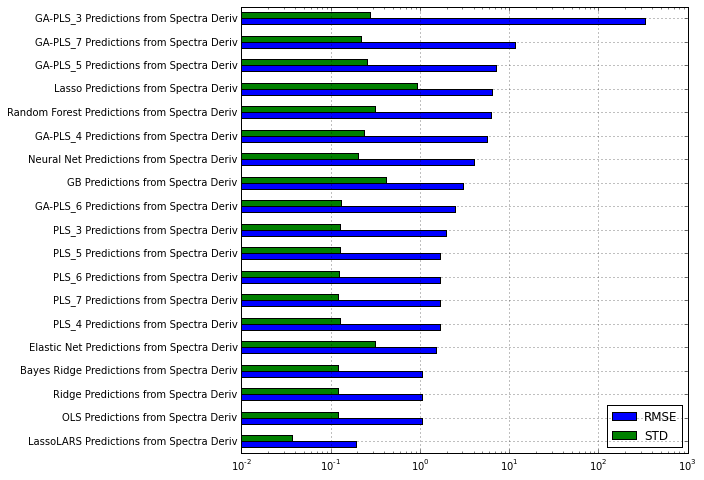

In [38]:
predRMSE=pd.DataFrame()
stdpred=predictions.groupby('True').std()

for ix,pred in enumerate(predictions):
    if ix>0:
        if pred.split(' Predictions from ')[1]=='Spectra Deriv':
            predRMSE[pred]= [rmse((predictions[pred]),(predictions['True']))]
    
predRMSE=predRMSE.rename(index={0:'RMSE'})
predRMSE=pd.concat([predRMSE.T.sort_index(),stdpred.mean()],ignore_index=False,axis=1)
predRMSE=predRMSE.rename(columns={0:'STD'})
#predRMSE.sort_index(by='RMSE')
predRMSE.sort_index(by='RMSE').head(19).plot(kind='barh',figsize=(8,8),logx=True)


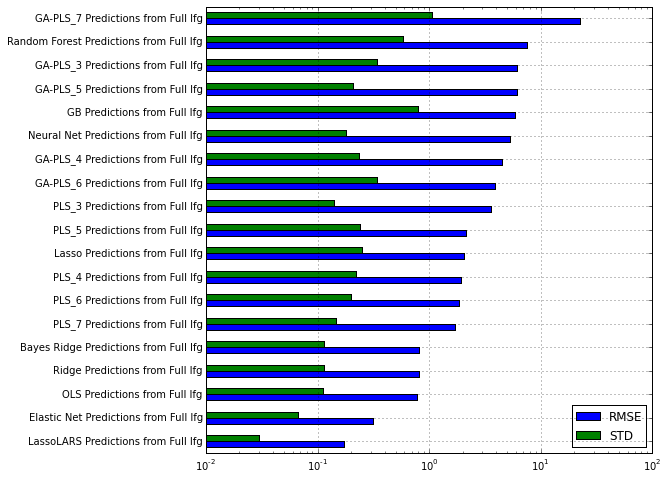

In [39]:
predRMSE=pd.DataFrame()
stdpred=predictions.groupby('True').std()

for ix,pred in enumerate(predictions):
    if ix>0:
        if pred.split(' Predictions from ')[1]=='Full Ifg':
            predRMSE[pred]= [rmse((predictions[pred]),(predictions['True']))]
    
predRMSE=predRMSE.rename(index={0:'RMSE'})
predRMSE=pd.concat([predRMSE.T.sort_index(),stdpred.mean()],ignore_index=False,axis=1)
predRMSE=predRMSE.rename(columns={0:'STD'})
#predRMSE.sort_index(by='RMSE')
predRMSE.sort_index(by='RMSE').head(19).plot(kind='barh',figsize=(8,8),logx=True)


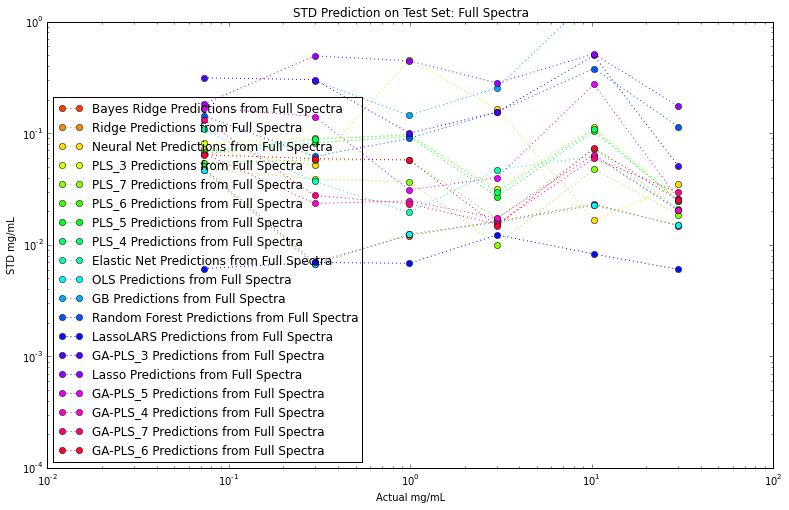

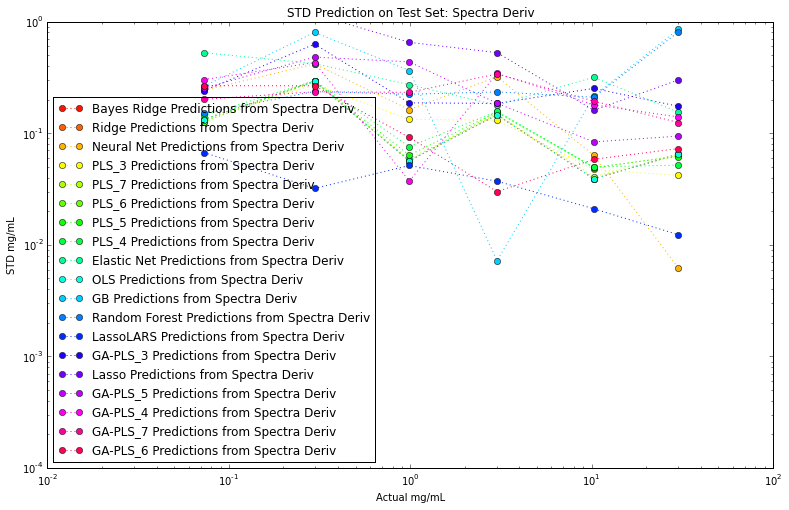

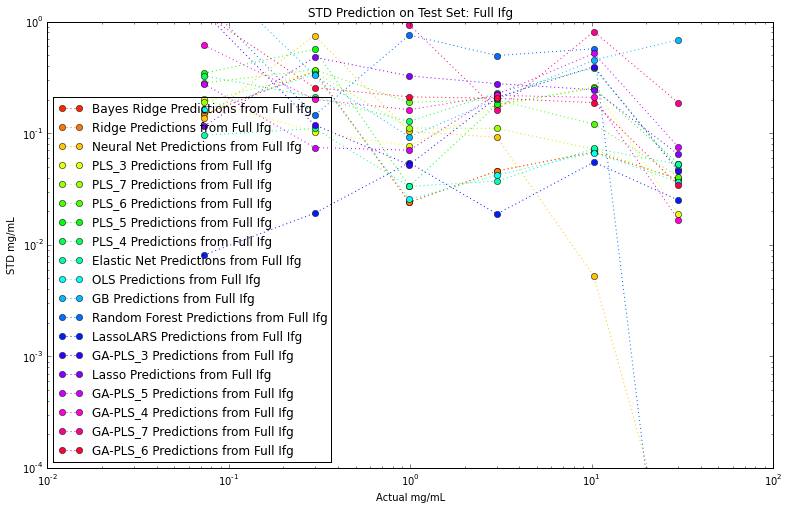

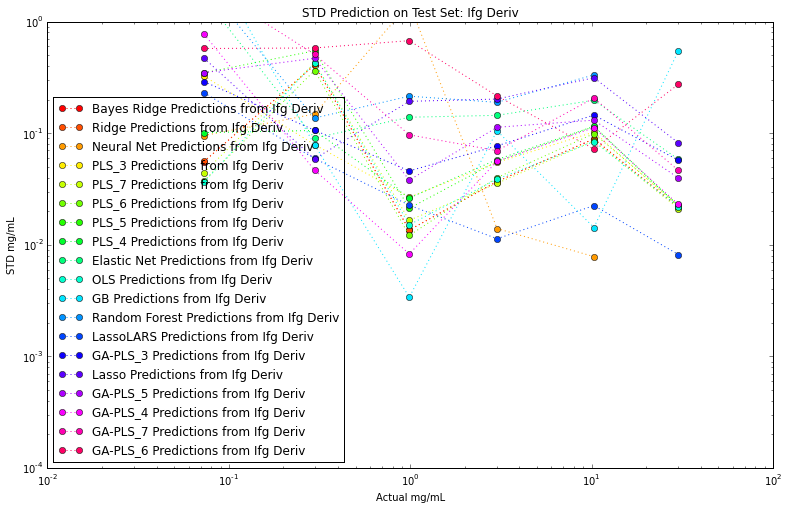

In [40]:
#%matplotlib qt
def stdplot_compare(datagrp):
    pl.figure(figsize=(13,8))
    stdpred=predictions.groupby('True').std()
    N=len(stdpred.columns)
    for ix,pred in enumerate(stdpred):
        if pred.find(datagrp)>0:
            color=cmap(float(ix)/N)
            pl.loglog((stdpred.index),(stdpred[pred]),marker='o',ls=':',label=pred,color=color)
    pl.legend(loc='best')
    pl.title('STD Prediction on Test Set: '+datagrp)
    pl.xlabel('Actual mg/mL')
    pl.ylabel('STD mg/mL')
    pl.ylim([0.0001,1])
stdplot_compare('Full Spectra')
stdplot_compare('Spectra Deriv')
stdplot_compare('Full Ifg')
stdplot_compare('Ifg Deriv')

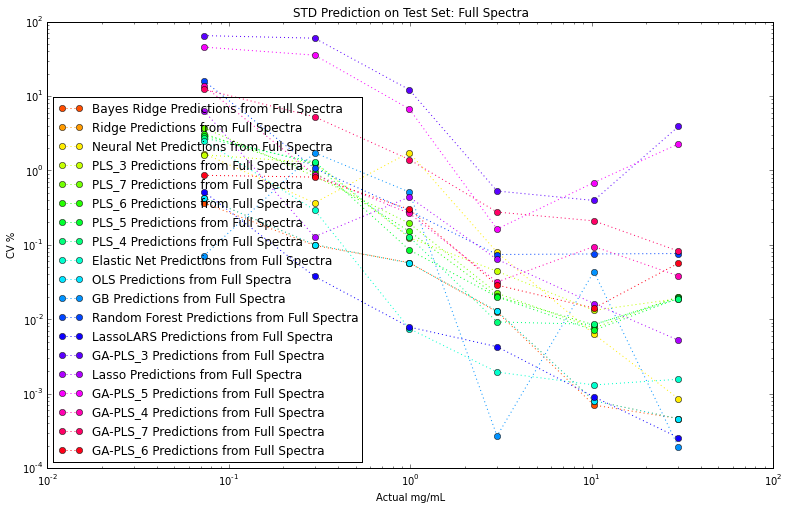

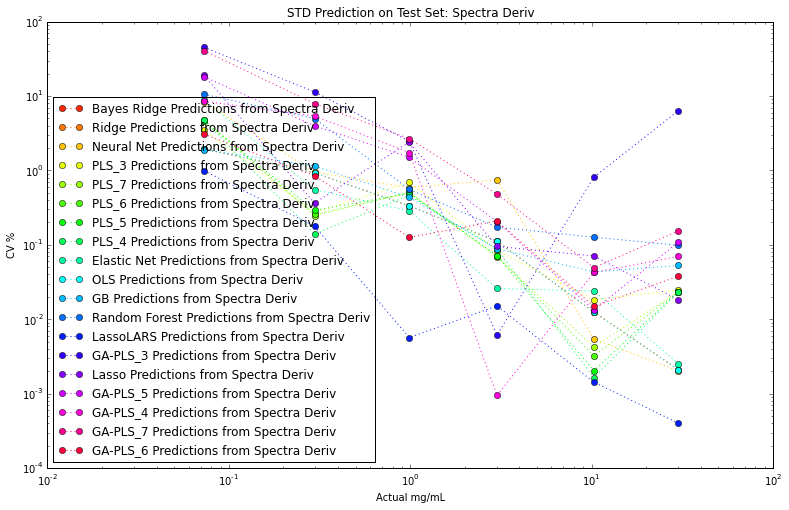

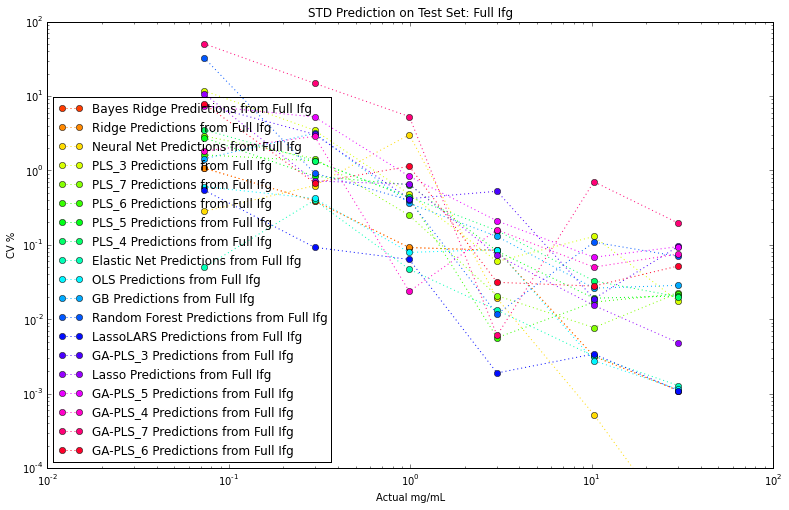

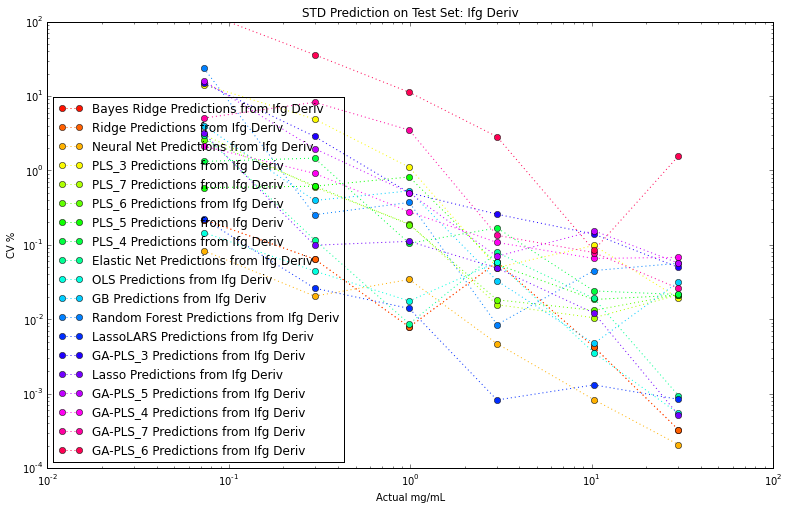

In [41]:
def pctCV_compare(datagrp):
    pl.figure(figsize=(13,8))
    medpred=predictions.groupby('True').median()
    N=len(stdpred.columns)
    for ix,pred in enumerate(predictions):
        if pred.find(datagrp)>0:
            color=cmap(float(ix)/N)
            pl.loglog((medpred.index),abs(medpred.index-medpred[pred])/medpred.index,marker='o',ls=':',label=pred,color=color)
    pl.legend(loc='best')
    pl.title('STD Prediction on Test Set: '+datagrp)
    pl.xlabel('Actual mg/mL')
    pl.ylabel('CV %')
    pl.ylim([0.0001,100])
pctCV_compare('Full Spectra')
pctCV_compare('Spectra Deriv')
pctCV_compare('Full Ifg')
pctCV_compare('Ifg Deriv')

From the results, Ridge, and OLS based approaches appeared to work the best using Ifg based predictiors.

Compare 'old' and 'new' approaches for sharing results:

PLS_4 Predictions from Spectra Deriv :  	 0.129
LassoLARS Predictions from Spectra Deriv :  	 0.03682
PLS_4 Predictions from Spectra Deriv :  	 1.669
LassoLARS Predictions from Spectra Deriv :  	 0.1934


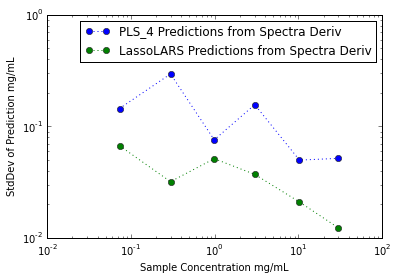

In [42]:
oldname='PLS_4 Predictions from Spectra Deriv'
newname='LassoLARS Predictions from Spectra Deriv'
pl.figure()
pl.loglog((stdpred.index),(stdpred[oldname]),marker='o',ls=':',label=oldname)
pl.loglog((stdpred.index),(stdpred[newname]),marker='o',ls=':',label=newname)
print oldname+' :  \t '+ "{:.4}".format(np.mean(stdpred[oldname]))
print newname+' :  \t '+ "{:.4}".format(np.mean(stdpred[newname]))
pl.legend(loc='best')
pl.xlabel('Sample Concentration mg/mL')
pl.ylabel('StdDev of Prediction mg/mL')
print oldname+' :  \t '+ "{:.4}".format(rmse((predictions[oldname]),(predictions['True'])))
print newname+' :  \t '+ "{:.4}".format(rmse((predictions[newname]),(predictions['True'])))


PLS_4 Predictions from Spectra Deriv :  	 0.129
LassoLARS Predictions from Spectra Deriv :  	 0.03682
PLS_4 Predictions from Spectra Deriv :  	 1.669
LassoLARS Predictions from Spectra Deriv :  	 0.1934


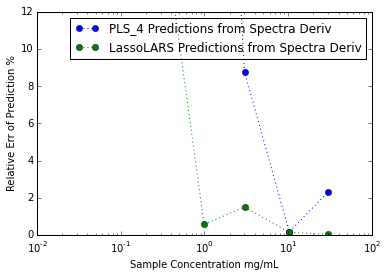

In [43]:
oldname='PLS_4 Predictions from Spectra Deriv'
newname='LassoLARS Predictions from Spectra Deriv'
medpred=predictions.groupby('True').median()
pl.figure()
pl.semilogx((medpred.index),100*abs(medpred.index-medpred[oldname])/medpred.index,marker='o',ls=':',label=oldname)
pl.semilogx((medpred.index),100*abs(medpred.index-medpred[newname])/medpred.index,marker='o',ls=':',label=newname)
print oldname+' :  \t '+ "{:.4}".format(np.mean(stdpred[oldname]))
print newname+' :  \t '+ "{:.4}".format(np.mean(stdpred[newname]))
pl.legend(loc='best')
pl.xlabel('Sample Concentration mg/mL')
pl.ylabel('Relative Err of Prediction %')
pl.ylim([0.0001,12])
print oldname+' :  \t '+ "{:.4}".format(rmse((predictions[oldname]),(predictions['True'])))
print newname+' :  \t '+ "{:.4}".format(rmse((predictions[newname]),(predictions['True'])))

# Conclusions

While the PLS approaches applied to the interferogram data was a bust, there are many opportunities to expolore with regression tools that are not factor based.  The next steps will be to collect more real data, and apply these approaches simultaneously with improving the synthetic data sets and better interferogram phase correction.

#Refrences

1. H. Mark and J. Workman Jr., *Chemometrics in Spectroscopy*, Elsevier, 2007
1. M. Kuhn and K. Johnson, *Applied Predictive Modeling*, Springer, 2013
1. P. Griffiths, J. de Haseth, *Fourier Transform Infrared Spectroscopy*, 2007
1. Pedregosa et al. “Scikit-learn: Machine Learning in Python”, *Journal of Machine Learning Research*, 2011, 12, 2825-2830
1. J. Bergstra, O. Breuleux, F. Bastien, P. Lamblin, R. Pascanu, G. Desjardins, J. Turian, D. Warde-Farley and Y. Bengio. “Theano: A CPU and GPU Math Expression Compiler”. *Proceedings of the Python for Scientific Computing Conference (SciPy)* 2010
1. F. Fortin, F. De Rainville, M. Gardner, M. Parizeau and C. Gagné, “DEAP: Evolutionary Algorithms Made Easy”, *Journal of Machine Learning Research*, 2012, 13, 2171-2175
1. Q. Ding and G. W. Small, “Genetic Algorithm-Based Wavelength Selection for the Near-Infrared Determination of Glucose in Biological Matrixes: Initialization Strategies and Effects of Spectral Resolution” *Analytical Chemistry* 1998, 70, 4472-4479
1. H. Yang, P.R. Griffiths, and J.D. Tate, “Comparison of partial least squares regression and multi-layer neural networks for quantification of nonlinear systems and application to gas phase Fourier transform infrared spectra” *Analytica Chimica Acta*, 489,2003, 125–136
1. M. J. Wabomba, G. W. Small, and M. A. Arnold, “Evaluation of selectivity and robustness of near-infrared glucose measurements based on short-scan Fourier transform infrared interferograms” *Analytica Chimica Acta* ,490, 2003, 325–340
